Import necessary packages: Numpy, Pandas, matplotlib

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

Mount your google drive (if you have a google account) or upload files (go on the file icon on the left -> right click). Copy path of zip.train and zip.test and load them as numpy arrays using the following code (insert the path as string).

In [13]:
path_to_train = '../data/zip.train'
path_to_test = '../data/zip.test'
training_data = np.array(pd.read_csv(path_to_train, sep=' ', header=None))
test_data = np.array(pd.read_csv(path_to_test, sep =' ',header=None))

X_train, y_train = training_data[:,1:-1], training_data[:,0]
X_test, y_test = test_data[:,1:], test_data[:,0]

# We only want to classify two different digits. Note the only difference is
# that we don't load as many ones as we load zeros.

X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1][:30]
#print(X_train_1.shape)
X_train = np.vstack((X_train_0, X_train_1))

y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1][:30]
y_train = np.hstack((y_train_0, y_train_1))

X_test_0 = X_test[y_test == 0]
X_test_1 = X_test[y_test == 1][:12]
X_test = np.vstack((X_test_0, X_test_1))

y_test_0 = y_test[y_test == 0]
y_test_1 = y_test[y_test == 1][:12]
y_test = np.hstack((y_test_0, y_test_1))
print(y_test.shape)

(371,)


In [5]:
def show_numbers(X):
    num_samples = 90
    indices = np.random.choice(range(len(X)), num_samples)
    print(indices.shape)
    sample_digits = X[indices]

    fig = plt.figure(figsize=(20, 6))

    for i in range(num_samples):
        ax = plt.subplot(6, 15, i + 1)
        img = 1-sample_digits[i].reshape((16, 16)) 
        plt.imshow(img, cmap='gray')
        plt.axis('off')


(90,)


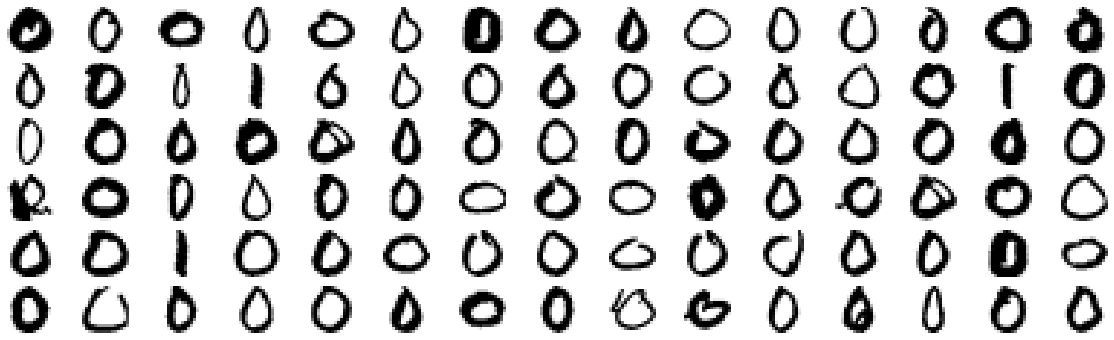

In [6]:
show_numbers(X_test)

Choose one of the classifiers you implemented and use it on the following task: Take a look at the provided notebook. It loads the ZIP-Code’s zeros and ones, but now there are manymore zeros than there are ones. We are going to believe that these digits represent geneticdata. Actually, we are virologists trying to develop a test to determine which of the data belongs to infected patients (the ones) and which do not (the zeros). Train/apply your model on the data and do the tasks of the exercise.

* Exercise 1.
- Use a 5-fold Cross-Validation to evaluate your model. 
- Print the mean and variance of your validation. 
- What do both values tell you about your model?

* Exercise 2.
- Calculate the confusion matrix of your model.

a) How many true positive/true negative/false positive/false negative observations arethere?

(b) Calculate the precision, recall, F1-score and state the difference between accuracy and F1-score

(c) If your test is positive, what is the probability for a patient to be actually positive. Would you recommend using the test you developed? Describe what the problem is if there is one.

I will work with K_NN Classifier

In [14]:
class KNearestNeighbors():
    
    def euclidean_distance(self, x_1, x_2):
      return np.sum((x_1-x_2)**2, axis = 1)

    def fit(self, X_train, y_train):
        # using regulary ML notation
        # https://scikit-learn.org/stable/tutorial/basic/tutorial.html
        # The for classifier is first fitted to the model; that is, it must learn from the model. 
        # This is done by passing our training set to the fit method. 
        self.X = X_train
        self.y = y_train
    
    def predict(self, X_test, k):
        # Now you can predict new values. In this case, we'll predict using the ona sample from the test dataset 
        # By predicting, w’ll determine the image from the training set (LABEL) that best matches the last image
        predictions = []
        for sample in X_test:
            # getting distance for each prticular data point
            distances = self.euclidean_distance(self.X, sample)
            # getting indexes of k first minimal elements
            # elements rearranged in such a way that the value of the element in k-th position 
            # is in the position it would be in a sorted array
            #idx = distances.argsort()[-3:][::-1]
            # https://stackoverflow.com/questions/34226400/find-the-index-of-the-k-smallest-values-of-a-numpy-array
            idx = np.argpartition(distances, k)[:k]
            # taking labels by indexes
            votes = (self.y[idx]).astype(int)
            # the class with maximum votes => the class with minimal distance to k nearest neighbors
            # numpy.argmax(numpy.bincount(dlabel)) returns the most common value found in dlabel.
            predictions.append(np.argmax(np.bincount(votes, minlength=10)))
        print("Done for k = {}".format(k))
        return predictions

kNN = KNearestNeighbors()
squared_distances = kNN.euclidean_distance(X_train, X_test[0])
print(squared_distances.shape)

(1224,)


In [15]:
def calculate_accuracy(labels, predictions):
        # Accuracy refers to the closeness of a measured value to a standard or known value
        # The accuracy is the fraction of images that the model classifies correctly.
        # Because we are measuring our model’s accuracy, we have created a set of images whose contents are known.
        # That is, we have a true label for each image, which is encoded as a class-ID.
        #  Next, we can use NumPy’s vectorized logical operations, specifically ==, to get a boolean-valued array
        # that stores True wherever the predicted labels match the true labels and False everywhere else.
        # Recall that True behaves like 1 and False like 0. Thus, we can call np.mean on our resulting boolean-valued array
        # to compute the number of correct predictions divided by the total number of predictions.
        return np.mean(labels == predictions)

In [19]:
print(training_data.shape)
print(test_data.shape)

model = KNearestNeighbors()

model.fit(X_train, y_train)

k = 3
results_train = []
accuracies_train = []

results_test = []
accuracies_test = []


res_train = model.predict(X_train, k)
acc_train = calculate_accuracy(y_train, res_train)
    
res_test = model.predict(X_test, k)
acc_test = calculate_accuracy(y_test, res_test)
results_test.append(res_test)
    
accuracies_train.append(acc_train)
accuracies_test.append(acc_test)
    
print(acc_test)
        

(7291, 258)
(2007, 257)
Done for k = 3
Done for k = 3
0.9973045822102425


In [158]:
# The first step is to pick a value for k 
# in order to determine the number of folds used to split the data. 
# Here, we will use a value of folds = 3. 

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# 1224 training samples
# 371 test samples

print(X_train.shape[0] / 5)

# so we have 5 folds every ~250 samples and the last is a little bit shorter

(1224, 256) (1224,) (371, 256) (371,)
244.8


In [161]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
import random
from sklearn.model_selection import KFold


kf = KFold(n_splits=5)

for train_index, test_index in kf.split(X_train):
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train_folds, X_test_folds = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

print("X_train_folds.shape:", X_train_folds.shape)
print("X_test_folds.shape:", X_test_folds.shape)

X_train_folds.shape: (980, 256)
X_test_folds.shape: (244, 256)
